# Lesson 1 - Jet tagging with neural networks

> A first look at training deep neural networks to tag jets in proton-proton collisions.

* Put dataset on the Hub with a loading script
* Figure out how to load `Dataset` objects in dataloaders
* Tidy up, add prose
* Add exercises
* Push model to Hub? => save for next lecture when we actually train from scratch
* Primer on N-subjettiness

## TODO

* Move `top_quark_tagging` to `dl4phys` org

## Learning objectives

* Understand what jet tagging is and how to frame it as a machine learning task
* Understand the main steps needed to train and evaluate a jet tagger
* Gain an introduction to the fastai library

## References

* Chapter 1 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.
* [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) by G. Kasieczka et al.

## The data

For the first few lessons, we'll be analysing the [_Top Quark Tagging_ dataset](https://zenodo.org/record/2603256), which is a famous benchmark that's used to compare the performance of jet classification algorithms. The dataset is described as follows:

* 14 TeV, hadronic tops for signal, qcd diets background, Delphes ATLAS detector card with Pythia8
* No MPI/pile-up included
* Clustering of  particle-flow entries (produced by Delphes E-flow) into anti-kT 0.8 jets in the pT range [550,650] GeV
* All top jets are matched to a parton-level top within ∆R = 0.8, and to all top decay partons within 0.8
* Jets are required to have |eta| < 2
* The leading 200 jet constituent four-momenta are stored, with zero-padding for jets with fewer than 200
* Constituents are sorted by pT, with the highest pT one first
* A flag (1 for top, 0 for QCD) is kept for each jet. It is called is_signal_new

Framed as a supervised machine learning task, the goal is to train a model that can classify each jet as either a top quark signal or quark-gluon background.

## Import libraries

In [3]:
import torch.nn.functional as F
from datasets import load_dataset
from fastai.tabular.all import *
from scipy.interpolate import interp1d
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
import datasets

# Suppress logs
datasets.logging.set_verbosity_error()

## Getting the data

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download and process the datasets that we'll encounter in this course. 🤗 Datasets provides smart caching and allows you to process larger-than-RAM datasets by exploiting a technique called _memory-mapping_ that provides a mapping between RAM and filesystem storage.

To download the Top Quark Tagging dataset, we can use the `load_dataset()` function:

In [9]:
dataset_id = "lewtun/top_quark_tagging"
top_quark_ds = load_dataset(dataset_id, name="raw", split="train", streaming=True)

To get a quick feel for what type of data we're dealing with, we've selected just the training split associated with the `raw` subset (which contains all the raw events). Since this dataset is rather large with 1.2 million events, we've also enabled _dataset streaming_ so we can grab a sample of events without having to load the whole dataset into RAM. The `take()` method returns the first $n$ examples in the datasets, so let's grab 5 events and load them in a pandas `DataFrame`:

In [12]:
sample = list(top_quark_ds.take(5))
pd.DataFrame(sample)

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
0,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


As we can see, each row consists of 4-vectors $(E_i, p_{x_i}, p_{y_i}, p_{z_i})$ that correspond to the maximum 200 particles that make up each jet. We can also see that each jet has been padded with zeros, since most won't have 200 particles. We also have an `is_signal_new` column that indicates whether the jet is a top quark signal (1) or QCD background (0).

Now that we've had a look at a sample of the raw data, let's take a look at how we can convert it to a format that is suitable for neural networks!

## Jet representations

In any machine learning problem, the first step is to decide how to represent the data. For jet tagging, the most common approaches one finds in the literature include:

* **Jets as images.** A jet image is a pixelated grayscale image, where the pixel intensity represents the energy (or transverse momentum) of all particles that deposited energy in a particular location in the $\eta-\phi$ plane. Typically, _convolutional neural networks (CNNs)_ (which we'll encounter later in the course) are used to process the images.
* **Jets as sequences.** Here the idea is to order the particles in a jet (usually by $p_T$) and use sequence-based architectures like _recurrent neural networks (RNNs)._
* **Jets as graphs.** This approach treats each jet as a generic graph of nodes and edges. Graph neural networks (which we'll also encounter later in the course) excel on this tpe of data.
* **Jets as sets.** A generalisation of the previous representations, this approach simply treats each jets as an unordered collection or point cloud of 4-vectors.
* **Theory-inspired representations.** Instead of representing the jets in formats to match specific neural network architectures, these approaches use results on IR safety from QCD to represent the jets as a simplified set of features. Fully-connected neural networks are then trained on these features.

You can find more details about each representation in a nice [review article](https://arxiv.org/abs/1709.04464) from 2017. In this lesson and the next, we'll use one of the theory-inspired representations called $N$-subjettiness. Let's take a look.

### Representing jets with $N$-subjettiness variables

The input variables spanning the $m$-body phase space are:

$$ \left\{ \tau_1^{(0.5)}, \tau_1^{(1)}, \tau_1^{(2)}, \tau_2^{(0.5)}, \tau_2^{(1)}, \tau_2^{(2)}, \ldots , \tau_{m-1}^{(0.5)}, \tau_{m-1}^{(1)}, \tau_{m-1}^{(2)} \right\} $$

where

$$ \tau_N^{(\beta)} = \frac{1}{p_{T,J}} \sum_{i\in J} p_{T,i} \left\{ R_{1,i}^\beta, R_{1,i}^\beta, \ldots , R_{1,i}^\beta \right\} $$

and $R_{n,i}$ is the distance in the $\eta-\phi$ plane of the jet constituent $i$ to the axis $n$. We've prepared a subset based on $N=4$

In [5]:
nsubjet_ds = load_dataset(dataset_id, name="nsubjettiness")
nsubjet_ds

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 1211000
    })
    validation: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 404000
    })
})

In [6]:
nsubjet_ds["train"][0]

{'tau_1_0.5': 543.6339721679688,
 'tau_1_1': 0.16512173414230347,
 'tau_1_2': 0.032661281526088715,
 'tau_2_0.5': 0.0022617217618972063,
 'tau_2_1': 0.048829928040504456,
 'tau_2_2': 0.003710513934493065,
 'tau_3_0.5': 4.390962203615345e-05,
 'tau_3_1': 0.030994312837719917,
 'tau_3_2': 0.0016299881972372532,
 'tau_4_0.5': 1.1181864465470426e-05,
 'tau_4_1': 0.001115332474000752,
 'tau_4_2': 7.765891496092081e-06,
 'is_signal_new': 0}

In [7]:
train_df, test_df = nsubjet_ds["train"].to_pandas(), nsubjet_ds["test"].to_pandas()

In [8]:
train_df.head()

,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,is_signal_new
0,543.633972,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,0.000011,0.001115,0.000008,0
1,452.411865,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,0.000163,0.005454,0.000072,0
2,429.495270,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,0.001385,0.012678,0.000567,0
3,512.675415,0.102580,0.011369,0.000170,0.086306,0.007759,0.000071,0.068169,0.005386,0.000048,0.002376,0.000008,0
4,527.956848,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,0.004359,0.033249,0.003689,0


## Introducing fastai

Now that we've downloaded our dataset of $N$-subjettiness variables, it's time to train a model! To do so, we'll use the [fastai library](https://github.com/fastai/fastai).

fastai is the most popular framework for training deep neural networks with PyTorch

**Basics of the API**

The most common steps one takes when training models in fastai are:

* Create `DataLoaders` to feed batches of data to the model
* Create a `Learner`
* Find a good learning rate
* Train your model
* Evaluate your model

Let's go through each of these steps to build a model neural network that can classify top quark jets from the QCD background.

### From data to DataLoaders

Now that we have downloaded our first dataset, it's time to wrangle it in a format that's suitable for training neural nets. In fastai, this means we need to create an object called `DataLoaders`.

To turn our dataset into a `DataLoaders` object we need to specify:

* What type of data we are dealing with (tabular, images, etc)
* How to get the examples
* How to label each example
* How to create the validation set

fastai provides a number of classes for different kinds of deep learning datasets and problems. In our case, the data is in a _tabular_ format (i.e. a table of rows and columns), so we can use the `TabularDataLoaders` class:

When training a neural network, it helps if the features are _normalized_. This means they should have a mean of 0 and standard deviation of 1

In [87]:
features = list(train_df.drop(columns="is_signal_new").columns)
features

['tau_1_0.5',
 'tau_1_1',
 'tau_1_2',
 'tau_2_0.5',
 'tau_2_1',
 'tau_2_2',
 'tau_3_0.5',
 'tau_3_1',
 'tau_3_2',
 'tau_4_0.5',
 'tau_4_1',
 'tau_4_2']

In [98]:
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    train_df, cont_names=features, procs=[Normalize], y_names="is_signal_new", bs=1024, y_block=CategoryBlock, splits=splits
)

Let's unpack this code a bit. We split our dataset into training and validaiton sets using the `RandomSplitter` class:

In [99]:
splits

((#968800) [56197,366255,1032564,106752,241088,829670,483972,868789,1142782,1033772...],
 (#242200) [429542,53893,1012620,698367,144414,346165,278364,990743,416382,260351...])

Explain `CategoryBlock` and `bs` and `y_names`

In [100]:
dls.show_batch()

,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,is_signal_new
0,498.544556,0.260912,0.074010,0.007595,0.195213,0.041322,0.002411,0.169998,0.031754,0.001457,0.019124,0.000840,0
1,482.895050,0.213169,0.073979,0.027584,0.180608,0.046207,0.009956,0.114265,0.017056,0.000886,0.016368,0.000768,0
2,410.474030,0.164448,0.035254,0.002981,0.170101,0.033576,0.002155,0.128885,0.019695,0.000684,0.013823,0.000350,0
3,498.679565,0.258445,0.072829,0.006580,0.184788,0.038667,0.002235,0.121545,0.020640,0.001104,0.010855,0.000441,0
4,492.061371,0.163927,0.041619,0.007241,0.188772,0.043883,0.006005,0.161858,0.033790,0.003192,0.030183,0.002896,0
5,446.236206,0.481773,0.240260,0.069948,0.237700,0.073457,0.017812,0.173881,0.047591,0.010803,0.010949,0.000250,1
6,402.010529,0.385039,0.169731,0.047613,0.265252,0.075067,0.007294,0.227845,0.056047,0.004244,0.030781,0.002290,0
7,513.663940,0.593441,0.360627,0.150350,0.164676,0.037833,0.004143,0.131939,0.023890,0.001614,0.018210,0.001122,0
8,518.095032,0.293858,0.104160,0.025159,0.133505,0.026451,0.005557,0.085117,0.012833,0.000698,0.008910,0.000271,0
9,566.478149,0.122993,0.022767,0.002247,0.140075,0.024543,0.001844,0.117204,0.017080,0.000697,0.009343,0.000447,0


### Create a Learner

We can now create the `Learner` for this data. fastai provides various application-specific learner classes, each of which come with a set of good defaults for training. In our case, we'll use the `tabular_learner` class:

In [106]:
learn = tabular_learner(dls, layers=[200, 200, 50, 50], metrics=[accuracy, RocAucBinary()])

By default, `tabular_learner` creates a neural network with two hidden layers and 200 and 100 activations each. This works great for small datasets, but since our dataset is quite large, we've increased the layer sizes to follow the models trained in the TOP paper.

Explain metrics!

In [102]:
learn.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 12           
BatchNorm1d                               24         True      
____________________________________________________________________________
                     1024 x 500          
Linear                                    6000       True      
ReLU                                                           
BatchNorm1d                               1000       True      
____________________________________________________________________________
                     1024 x 250          
Linear                                    125000     True      
ReLU                                                           
BatchNorm1d                               500        True      
____________________________________________________________________________
                     1024 x 2            
Linear                                    502       

### Find a good learning rate

The learning rate is one of the most important hyperparameters involved in training neural networks, so it's important to make sure you've picked a good one. We'll see in the next lesson exactly how this parameter impacts training, but for now it is enough to know that:

* If our learning rate is too low, it will take a long time to train the model and there is a good chance of overfitting.
* If our learning rate is too high, the training process can diverge.

To handle these two extremes, fastai provides a _learning rate finder_ that tracks the loss as we increase the learning rate. You can see this in action by using the `lr_find()` method of any `Learner`:

SuggestedLRs(valley=0.0004786300996784121)

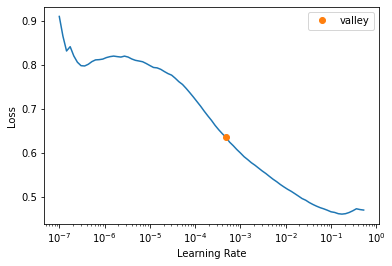

In [103]:
learn.lr_find()

From this curve we can see that the loss hits a minimum around a learning rate of $10^{-1}$, so we should select a learning rate lower than this point. The `lr_find()` method provides a handy heuristic to pick the learning rate 1-2 orders of magnitude less than the minimum, as indicated by the orange dot. 

### Train your model

In the above learning rate plot, it appears a learning rate of around 1e-3 would be good, so let's choose that and train our models for 3 epochs:

In [104]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.252123,0.255389,0.890339,0.960738,00:09
1,0.239361,0.265305,0.884637,0.962879,00:09
2,0.235983,0.238520,0.898233,0.965554,00:08


In [105]:
learn.show_results()

,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,is_signal_new,is_signal_new_pred
0,-1.376523,4.594972,6.010813,5.846083,7.976869,16.290916,17.533812,3.225185,2.317800,0.054715,2.878208,0.044014,0.0,1.0
1,0.167754,6.075053,8.852554,9.232345,-0.587539,-0.258293,-0.089548,0.133121,-0.065474,-0.062394,-0.361122,-0.052347,1.0,1.0
2,1.210905,-0.645891,-0.355371,-0.150949,-1.062659,-0.531901,-0.107301,-1.202551,-0.588638,-0.069788,-0.632673,-0.054422,0.0,0.0
3,0.277164,0.410864,0.028530,-0.133403,0.520584,0.113476,-0.084857,0.415824,-0.007083,-0.063247,-0.035965,-0.048590,1.0,1.0
4,0.840164,0.363139,0.024072,-0.129844,-0.084457,-0.200150,-0.096873,0.139287,-0.169419,-0.066444,-0.257229,-0.052007,1.0,1.0
5,0.045469,-1.281096,-0.522245,-0.159474,-0.897064,-0.487824,-0.106488,-0.623635,-0.431098,-0.068687,-0.392357,-0.052944,0.0,0.0
6,-1.622919,0.867787,0.235317,-0.119613,0.839574,0.233134,-0.082222,1.016901,0.478297,-0.042277,0.478922,-0.036452,1.0,1.0
7,0.278660,0.590895,0.105733,-0.126660,1.006151,0.339890,-0.074578,-0.082029,-0.227002,-0.066363,-0.155595,-0.050178,1.0,1.0
8,-0.775944,1.059352,0.338674,-0.110680,1.537342,0.694907,-0.056490,0.872411,0.308472,-0.052857,0.318780,-0.042965,1.0,1.0


### Evaluate your model

Note that in addition to accuracy, we also show a second value, the Area Under the ROC Curve (AUC). The AUC is a good summary statistic of the predictiveness of a binary classifier. It varies from zero to one, and a value of 0.5 corresponds to randomness (the classifier cannot distinguish at all between "signal" and "background"), while a value of 1.0 means that it is perfect.

The "ROC" refers to the Receiver Operating Characteristic curve which plots the true positive rate

$$ \mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}} \,, \qquad \mathrm{TP\, (FP)} = \mathrm{number\, of\, true\, (false) \,positives}\,, $$

against the false positive rate FPR, where the FPR is the ratio of negative instances that are incorrectly classified as positive. In general there is a tradeoff between these two quantities: the higher the TPR, the more false positives (FPR) the classifier produces.

For our analysis, these ROC curves effectively plot signal efficiency versus background rejection at various thresholds of some discriminating variable.

In [113]:
test_dl = learn.dls.test_dl(test_df)
preds = learn.get_preds(dl=test_dl)

In [114]:
signal_test = preds[0][:, 1][test_df["is_signal_new"].values == 1].numpy()
background_test = preds[0][:, 1][test_df["is_signal_new"].values == 0].numpy()

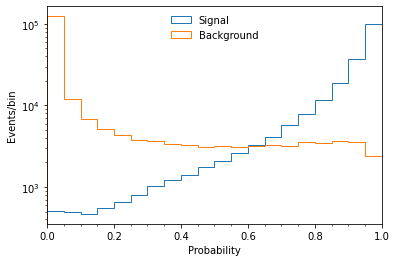

In [117]:
plt.hist(signal_test, histtype='step',
         bins=20, range=(0, 1), label='Signal')
plt.hist(background_test, histtype='step', 
         bins=20, range=(0, 1), label='Background')
plt.xlabel('Probability')
plt.ylabel('Events/bin')
plt.yscale('log')
plt.xlim(0, 1)
plt.minorticks_on()

plt.legend(loc='upper center', frameon=False)
plt.show()

As expected, the background events are clustered around 0 and the signal events are clustered around 1. Imagine cutting the data, and only the datapoints with a score larger than a certin number. If we start the cut at 0, all of the events make it through, so we have a signal efficiency $\epsilon_S$ and a background efficiency $\epsilon_B$ equal to 1. In the opposite extreme, we could only take events with a score larger than 1, in which case no events pass, thus $\epsilon_S = \epsilon_B = 0$. As we scan the value of the cut, $\epsilon_S$ and $\epsilon_B$ will work from 0 to 1, plotting these parametrically defines the ROC Curve. If $\epsilon_S=\epsilon_B$ everywhere, our model is never gaining an advantage over random guessing.

To compute the ROC curve, we will use part of scikit-learn.

In [66]:
preds[0].argmax(dim=-1)

tensor([0, 0, 0,  ..., 1, 1, 1])

In [67]:
accuracy_score(test_df["is_signal_new"], preds[0].argmax(dim=-1))

0.8897945544554455

In [68]:
rc = roc_curve(test_df["is_signal_new"], preds[0][:, 1])

In [69]:
len(rc)

3

In [70]:
rc[0].shape

(86735,)

In [71]:
rc[1].shape

(86735,)

In [72]:
rc[2].shape

(86735,)

(0.0, 1.0)

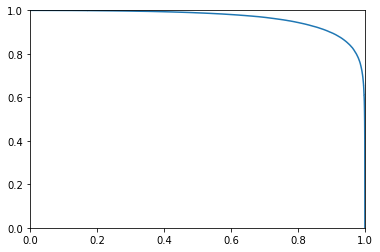

In [73]:
plt.plot(rc[1], 1 - rc[0], "-")
plt.xlim(0, 1)
plt.ylim(0, 1)

In [118]:
fpr_n, tpr_n, thresholds_n = roc_curve(
    y_true=test_df["is_signal_new"], y_score=preds[0][:, 1]
)

In [119]:
auc_n = auc(fpr_n, tpr_n)

background_eff_n = interp1d(tpr_n, fpr_n)
working_point_n = background_eff_n(0.3)

print(f"The area under the curve is {auc_n:0.3f}")
print(f"The backround rejection at signal efficieny 0.3 is {1/working_point_n:0.3f}")

The area under the curve is 0.965
The backround rejection at signal efficieny 0.3 is 276.595


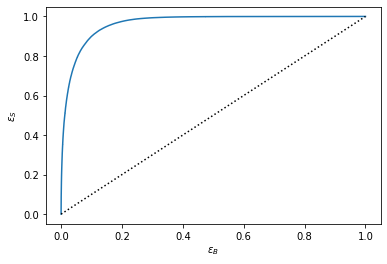

In [120]:
#Plot the epsilon_S along the y axis and epsilon_B along the x
plt.plot(fpr_n, tpr_n)
plt.plot([0,1], [0, 1], ls=':', color='k')  # interpolating between all events and no events
plt.xlabel(r'$\epsilon_B$')
plt.ylabel(r'$\epsilon_S$')
plt.show()

/tmp/ipykernel_8851/1205818864.py:2: RuntimeWarning: divide by zero encountered in true_divide
  1/fpr_n,


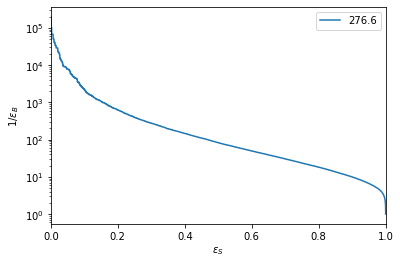

In [121]:
plt.plot(tpr_n,
         1/fpr_n,
         label='{0:.1f}'.format(1/working_point_n)
        )
plt.xlabel('$\epsilon_{S}$')
plt.ylabel('$1/\epsilon_{B}$')
plt.xlim(0,1)
plt.yscale('log')
plt.legend()
plt.show()

## Exercises

* Add susy dataset and use as exercise!